# Tutorial 6: Part II : Anomaly Detection

Anomaly detection is the task of 

1) identifying instances whose characteristics differ significantly from the 
rest of the data. 

2) creating labels for first time unseen data so that to serve as training data for classification analysis.

## Question 4:  Statistical Approach

This approach assumes that the **majority** of the data instances are governed by some well-known probability 
distribution, e.g., **Binomial or Gaussian distribution**. **Anomalies** can then detected by seeking for observations 
**that do not fit the overall distribution** of the data.

In this question, we are detecting anomalous changes in the daily closing prices of various stocks. The input data 
**stocks.csv** contains the historical closing prices of stocks for **3** large corporations of IT, Car maufacturer and bank
**(Microsoft, Ford Motor, and Bank of America)**.

__Step 1: Import T6_Q4_stocks.csv__

**<font color="red">Code:</font>**

In [1]:
import pandas as pd

stocks = pd.read_csv('T6_Q4_stocks.csv', header='infer' ) 
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)

print(stocks.shape)

(2518, 3)


In [2]:
stocks

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000
...,...,...,...
12/23/2016,63.240002,12.46,22.600000
12/27/2016,63.279999,12.39,22.610001
12/28/2016,62.990002,12.25,22.330000


__Step 2: Create rule to detect anomaly__

We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

**<font color="red">Code:</font>**

In [3]:
import numpy as np

N,d = stocks.shape
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536
...,...,...,...
12/23/2016,-0.487800,0.483871,0.266189
12/27/2016,0.063246,-0.561798,0.044252
12/28/2016,-0.458276,-1.129944,-1.238394


__Step 3: Plot the distribution based on the rule change__

We can plot the distribution of the **percentage daily changes** in stock price.

**<font color="red">Code:</font>**

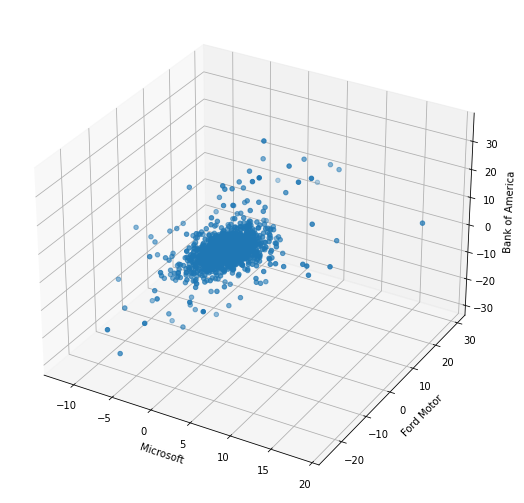

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (12,9) # The default value of the figsize parameter is [6.4, 4.8]

fig = plt.figure(figsize=(12,9)).gca(projection='3d')
fig.scatter(delta.MSFT,delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford Motor')
fig.set_zlabel('Bank of America')
_ = plt.show()

__Step 4: Find the data distribution parameters (mean and variance) of the 3 company features__
    
Assuming the data follows a multivariate Gaussian distribution, we can compute the mean and covariance matrix of 
the 3-dimensional data as follows

**<font color="red">Code:</font>**

In [5]:
meanValue = delta.mean()
covValue = delta.cov()
print('meanValue', '\n', meanValue)
print('\n')
print('covValue',  '\n', covValue)

meanValue 
 MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64


covValue 
           MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


**<font color="blue">Observation:</font>**

Can you understand the covariance between pairs such as MSFT and Ford? 

Which one are the variances, $\sigma^2$ of the three company?

__Step 5 : Detect Anomaly__

To determine the anomalous trading days, we can compute the Mahalanobis distance between the percentage of price 
change on each day against the mean percentage of price change.
\begin{equation}
\textrm{Mahalanobis}(x) = (x - \bar{x}) \Sigma^{-1}(x - \bar{x})^T
\end{equation}
where $x$ is assumed to be a row vector.

**<font color="red">Code:</font>**

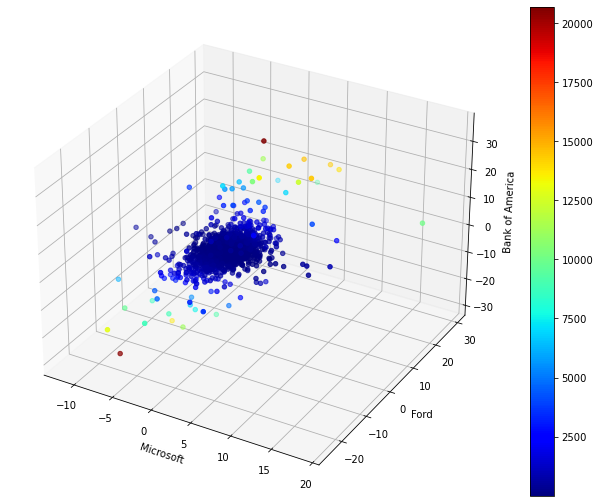

In [6]:
X = delta.values
S = covValue.values
for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    # matmul: Matrix product of two arrays
    # dot: Dot product of two arrays
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis(mahalanobis, axis=1, arr=X) # Apply a function to 1-D slices along the given axis.

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

**<font color="blue">Observation:</font>**

The top-2 anomalies are shown as a brown point in the figure above. 

The highest anomaly corresponds to the day in which the prices for all 3 stocks increase significantly.

The second highest anomaly corresponds to the day in which all 3 stocks suffer a large percentage drop in their closing prices. 

__Step 6 : Examine the data associated with the top-5 highest anomaly scores__

**<font color="red">Code:</font>**

In [7]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5,'Anomaly score') # Return the first n rows with the largest values in columns, in descending order

,MSFT,F,BAC,Anomaly score
Date,,,,
4/9/2009,2.456295,7.280398,35.235771,20691.465032
10/7/2008,-6.789282,-20.928583,-26.259300,20471.095209
7/16/2008,4.199739,18.003142,22.374857,14586.725381
3/10/2009,8.733875,6.260465,27.699983,14460.021473
11/24/2008,5.087116,9.029535,27.168044,14360.912124


(                MSFT          F        BAC
 Date                                      
 10/2/2008  -0.913583  -4.456979  -4.649144
 10/3/2008   0.221664  -6.957926  -5.229939
 10/6/2008  -5.402146  -8.950263  -6.587872
 10/7/2008  -6.789282 -20.928583 -26.259300
 10/8/2008  -0.992054  -8.965484  -7.059013
 10/9/2008  -3.130622 -21.865885 -11.209826
 10/10/2008 -3.632442  -4.388297   6.283522,
                MSFT          F        BAC
 Date                                     
 4/7/2009  -0.045003  -7.488430  -1.637629
 4/8/2009   2.247113  13.119142  -4.109438
 4/9/2009   2.456295   7.280398  35.235771
 4/13/2009 -0.451713   0.410324  15.359319
 4/14/2009 -1.270118   0.877593  -8.472552
 4/15/2009 -2.732341  -6.107886   3.435430
 4/16/2009  4.893924   2.908923  -0.991205)

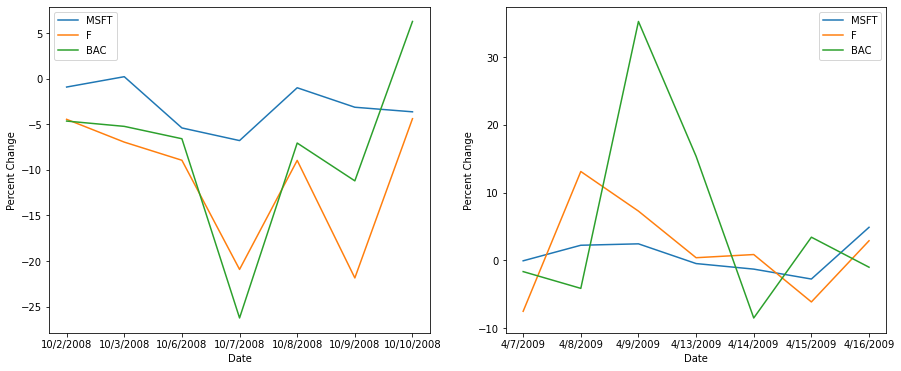

In [8]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts1 = delta[440:447]
_ = ts1.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts1.index)
ax1.set_ylabel('Percent Change')

ts2 = delta[568:575]
_ = ts2.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts2.index)
ax2.set_ylabel('Percent Change')
ts1, ts2

**<font color="blue">Observation:</font>** 

Sharp drop in the stock prices on **October 7, 2008** coincide with the beginning of the global financial crisis. 

Increase in the stock prices on **April 9, 2009**.

(https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008) 

## Question 5: Proximity Based Approach

This is a model-free anomaly detection approach as it does not require constructing an explicit model of the normal class to determine the anomaly score of data instances. 

**k-nearest neighbor** approach is to calculate **anomaly score**. 

Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbor whereas an anomaly is likely to have a large distance to its k-th nearest neighbor. 

Distance-based approach with **k=4** to identify the anomalous trading days from the stock market data as described in Question 4.

__Step 1 : Import the NearestNeighbours from sklearn.neighbours__
    
1) set knn=4, metric= distance.euclidean

2) fit the delta data 

3) list the 4th nearest neighbour as anomaly score 

4) plot the 3D plot of the 3 companies and their anomaly score

**<font color="red">Code:</font>**

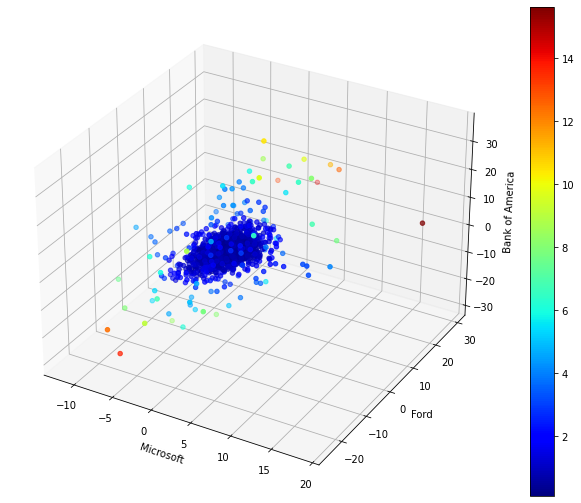

In [9]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance


knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.values)
distances, indices = nbrs.kneighbors(delta.values)

anomaly_score = distances[:,knn-1]

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

**<font color="blue">Observation:</font>** 

The results are slightly different than the one shown in Question 4 as we have used **Euclidean distance 
(instead of Mahalanobis distance)** to detect the anomalies. 

__Step 2 : Examine the data associated with the top-5 highest anomaly scores__

**<font color="red">Code:</font>**

In [10]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.559648,20.039128,9.166457,15.642827
11/26/2008,2.456248,29.456698,4.223406,14.212749
10/7/2008,-6.789282,-20.928583,-26.259300,13.751302
11/28/2008,-1.362724,25.054905,5.280972,13.139586
9/30/2008,6.672314,24.638866,15.669129,12.599739


Text(0, 0.5, 'Percent Change')

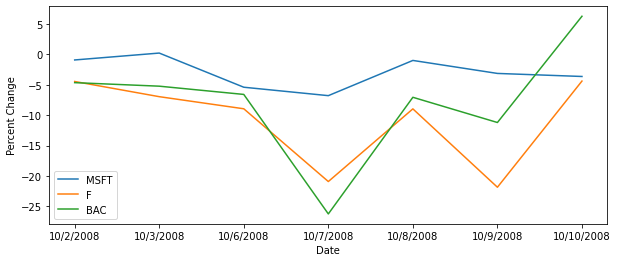

In [11]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[440:447]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

**<font color="blue">Observation:</font>** 

KNN distance based approach predicts the same stock crash at **Oct 7, 2008**.